#  **Starbucks Capstone Challenge**

### **Introduction**

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 
 
Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### **Example**

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### **Cleaning**

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### **Final Advice**

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# **Data Sets**

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record



In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import f1_score
import seaborn as sns
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

#**DATA** **EXPLORATION**

**1) EXPLORING PORTFOLIO DATA**

In [2]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [3]:
print("portfolio: Rows = {0}, Columns = {1}".format(str(portfolio.shape[0]), str(portfolio.shape[1])))


portfolio: Rows = 10, Columns = 6


In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [5]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [6]:
portfolio.isnull().any()

reward        False
channels      False
difficulty    False
duration      False
offer_type    False
id            False
dtype: bool

In [7]:
portfolio['offer_type'].value_counts()

discount         4
bogo             4
informational    2
Name: offer_type, dtype: int64

In [8]:
def horizontal_bar_graph(df,colname,title):
    '''
    Creats a horizontal bar of value counts of colname column of dataframe df
    
    Parameters:
    df = Input Dataframe
    colname = Name of the column to plot in dataframe df
    title = Title of the graph

    Return: None

    '''
    Graph_df=df[colname].value_counts()

    plt.bar(Graph_df.index,Graph_df.values)
    plt.title(title)
    plt.show()


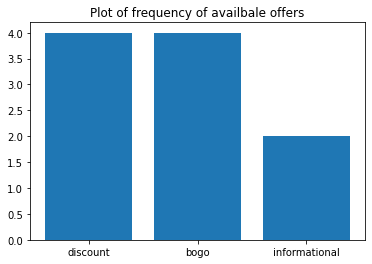

In [9]:
horizontal_bar_graph(portfolio,'offer_type','Plot of frequency of availbale offers')

**2) EXPLORING PROFILE DATA**

In [10]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [11]:
print("profile: Rows = {0}, Columns = {1}".format(str(profile.shape[0]), str(profile.shape[1])))


profile: Rows = 17000, Columns = 5


In [12]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [13]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [14]:
profile.isnull().any()

gender               True
age                 False
id                  False
became_member_on    False
income               True
dtype: bool

In [15]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [16]:
profile['age'].value_counts()

118    2175
58      408
53      372
51      363
54      359
       ... 
100      12
96        8
98        5
99        5
101       5
Name: age, Length: 85, dtype: int64

In [17]:
profile[profile['age']==118]

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


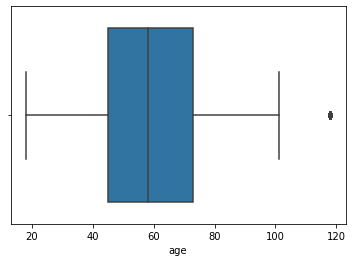

In [18]:
sns.boxplot(profile['age'])

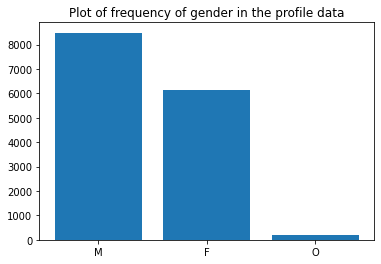

In [19]:
horizontal_bar_graph(profile,'gender','Plot of frequency of gender in the profile data')

**3) EXPLORING TRANSCRIPT DATA**

In [20]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [21]:
print("transcript: Rows = {0}, Columns = {1}".format(str(transcript.shape[0]), str(transcript.shape[1])))


transcript: Rows = 306534, Columns = 4


In [22]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [23]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


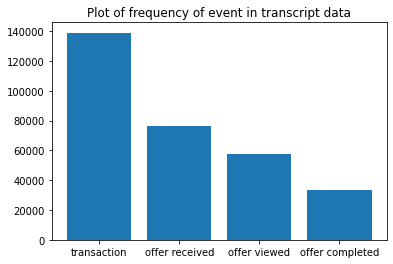

In [24]:
horizontal_bar_graph(transcript,'event','Plot of frequency of event in transcript data')

#**DATA PREPARATION AND CLEANING**

**1) CLEANING PORTFOLIO DATA**

In [25]:
# Replacing column names with appropriate names

new_cols_name = {'difficulty':'offer_difficulty' , 'id':'offer_id', 'duration':'offer_duration', 'reward': 'offer_reward'}
portfolio = portfolio.rename(columns = new_cols_name)

In [26]:
portfolio.head()

,offer_reward,channels,offer_difficulty,offer_duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [27]:
portfolio.columns

Index(['offer_reward', 'channels', 'offer_difficulty', 'offer_duration',
       'offer_type', 'offer_id'],
      dtype='object')

**2) CLEANING PROFILE DATA**

In [28]:
profile=profile.dropna(axis=0)

In [29]:
profile.isnull().any()

gender              False
age                 False
id                  False
became_member_on    False
income              False
dtype: bool

In [30]:
#rename columns
cols_profile = {'id':'customer_id' , 'income':'customer_income'}
profile=profile.rename(columns=cols_profile)

In [31]:
# Deleting entries of age less than 80

profile=profile[profile['age']<=80]


In [32]:
# Replacing column age with Age-Group
profile.loc[(profile.age < 20) , 'Age_group'] = 'Under 20'
profile.loc[(profile.age >= 20) & (profile.age <= 45) , 'Age_group'] = '20-45'
profile.loc[(profile.age >= 46) & (profile.age <= 60) , 'Age_group'] = '46-60'
profile.loc[(profile.age >= 61) , 'Age_group'] = '61-80'
profile.drop('age',axis=1,inplace=True)

In [33]:
profile.head()

,gender,customer_id,became_member_on,customer_income,Age_group
1,F,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,46-60
3,F,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,61-80
5,M,e2127556f4f64592b11af22de27a7932,20180426,70000.0,61-80
8,M,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,61-80
12,M,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,46-60


**3) CLEANING TRANSCRIPT DATA**

In [34]:
# rename columns

trans_columns = {'person':'customer_id'}
transcript=transcript.rename(columns=trans_columns)

In [35]:
# expanding columns

transcript['offer_id']=transcript['value'].apply(lambda x : x.get('offer_id'))
transcript['offer id']=transcript['value'].apply(lambda x : x.get('offer id'))
transcript['money_gained']=transcript['value'].apply(lambda x : x.get('reward'))
transcript['money_spent']=transcript['value'].apply(lambda x : x.get('amount'))

# Merging column offer_id and offer id
transcript['offer_id']=transcript.apply(lambda x : x['offer id'] if x['offer_id'] == None else x['offer_id'], axis=1)

transcript = transcript.drop(['offer id','value'],axis=1)

transcript.fillna(0,inplace=True)

In [36]:
transcript.head()

,customer_id,event,time,offer_id,money_gained,money_spent
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0


**4) MERGING THE DATA**

In [37]:
# Merging Portfolio, Profile and Transcript data

merged_df = pd.merge(portfolio, transcript, on='offer_id')
merged_df = pd.merge(merged_df, profile, on='customer_id')

In [38]:
merged_df.head()

,offer_reward,channels,offer_difficulty,offer_duration,offer_type,offer_id,customer_id,event,time,money_gained,money_spent,gender,became_member_on,customer_income,Age_group
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer received,0,0.0,0.0,M,20170909,100000.0,61-80
1,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer viewed,102,0.0,0.0,M,20170909,100000.0,61-80
2,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer received,504,0.0,0.0,M,20170909,100000.0,61-80
3,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer viewed,510,0.0,0.0,M,20170909,100000.0,61-80
4,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer completed,510,10.0,0.0,M,20170909,100000.0,61-80


In [39]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138727 entries, 0 to 138726
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   offer_reward      138727 non-null  int64  
 1   channels          138727 non-null  object 
 2   offer_difficulty  138727 non-null  int64  
 3   offer_duration    138727 non-null  int64  
 4   offer_type        138727 non-null  object 
 5   offer_id          138727 non-null  object 
 6   customer_id       138727 non-null  object 
 7   event             138727 non-null  object 
 8   time              138727 non-null  int64  
 9   money_gained      138727 non-null  float64
 10  money_spent       138727 non-null  float64
 11  gender            138727 non-null  object 
 12  became_member_on  138727 non-null  int64  
 13  customer_income   138727 non-null  float64
 14  Age_group         138727 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 16.9+ MB


**5) ANALYZING MERGED DATA**

In [40]:
def plot_statistics(df,colname1,colname2):
    plt.figure(figsize=(15, 5))
    sns.countplot(x= colname1, hue= colname2, data=df)
    sns.set(style="darkgrid")
    plt.title(colname2+' distribution in events')
    plt.ylabel('Count')
    plt.xlabel(colname1)
    plt.legend(title=colname2)

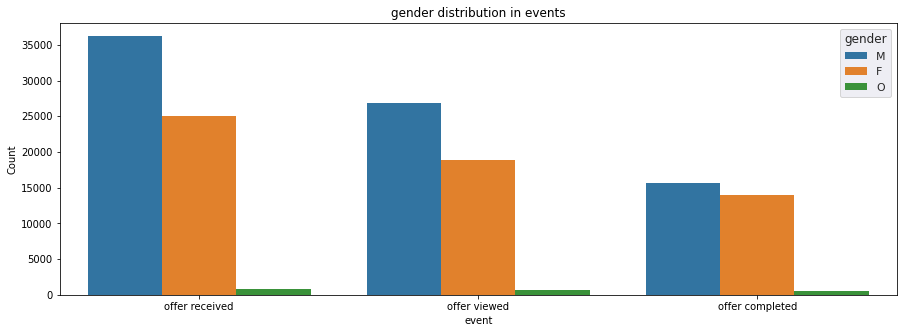

In [41]:
# Gender distribution of all the events

plot_statistics(merged_df,"event","gender")

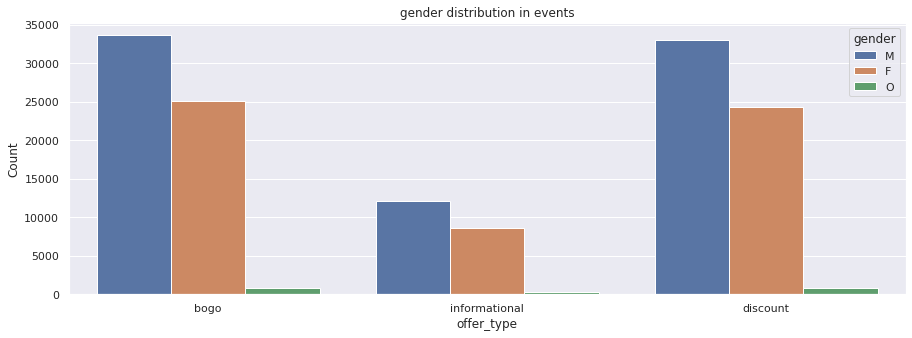

In [42]:
# Gender distribution of all the offer type

plot_statistics(merged_df,'offer_type','gender')

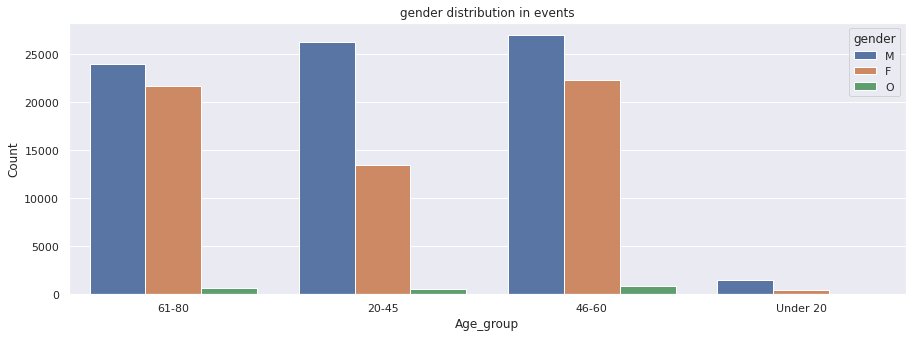

In [43]:
# Gender distribution of all age groups

plot_statistics(merged_df,'Age_group','gender')

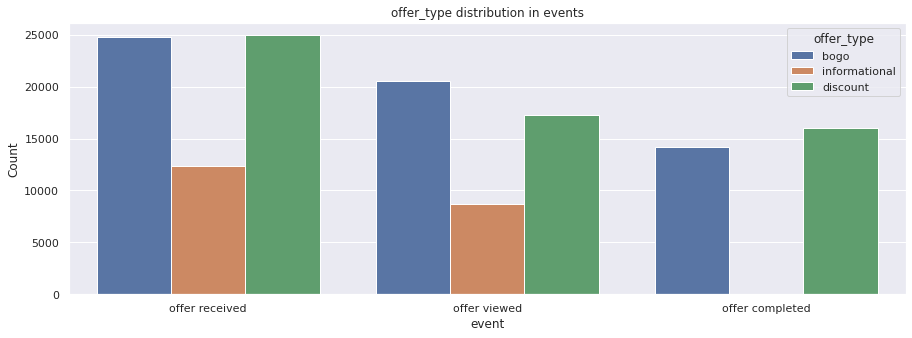

In [44]:
# Offer Type distribution of all events

plot_statistics(merged_df,'event',"offer_type")

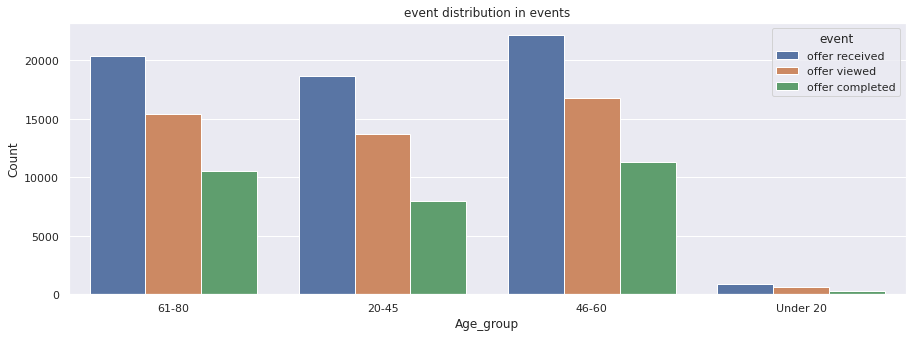

In [45]:
# Event distribution of all the age group

plot_statistics(merged_df,'Age_group','event')

**6) CLEANING THE MERGED DATA**


In [46]:
# Changing Categorical Data

merged_df['email'] = merged_df['channels'].apply(lambda x: 1 if 'email' in x else 0)
merged_df['web'] = merged_df['channels'].apply(lambda x: 1 if 'web' in x else 0)
merged_df['mobile'] = merged_df['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
merged_df['social'] = merged_df['channels'].apply(lambda x: 1 if 'social' in x else 0)
merged_df = merged_df.drop(['channels'],axis=1)

categorical_cols=['offer_type', 'Age_group', 'gender']
merged_df = pd.get_dummies(merged_df,columns=categorical_cols)

#encode 'event' data to numerical values according to task 2
merged_df['event'] = merged_df['event'].map({'offer received':1, 'offer viewed':2, 'offer completed':3})

merged_df.head()

,offer_reward,offer_difficulty,offer_duration,offer_id,customer_id,event,time,money_gained,money_spent,became_member_on,customer_income,email,web,mobile,social,offer_type_bogo,offer_type_discount,offer_type_informational,Age_group_20-45,Age_group_46-60,Age_group_61-80,Age_group_Under 20,gender_F,gender_M,gender_O
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,1,0,0.0,0.0,20170909,100000.0,1,0,1,1,1,0,0,0,0,1,0,0,1,0
1,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,2,102,0.0,0.0,20170909,100000.0,1,0,1,1,1,0,0,0,0,1,0,0,1,0
2,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,1,504,0.0,0.0,20170909,100000.0,1,0,1,1,1,0,0,0,0,1,0,0,1,0
3,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,2,510,0.0,0.0,20170909,100000.0,1,0,1,1,1,0,0,0,0,1,0,0,1,0
4,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,3,510,10.0,0.0,20170909,100000.0,1,0,1,1,1,0,0,0,0,1,0,0,1,0


In [47]:
# Cleaning numerical data

# Processing customer id
cus_ids = list(merged_df['customer_id'].unique())
cus_id_dict = dict(zip(cus_ids,range(len(cus_ids))))
merged_df['customer_id'] = merged_df['customer_id'].apply(lambda x : cus_id_dict[x])

# Processing offer id
offer_ids = list(merged_df['offer_id'].unique())
offer_id_dict = dict(zip(offer_ids,range(len(offer_ids))))
merged_df['offer_id'] = merged_df['offer_id'].apply(lambda x : offer_id_dict[x])

# Processing column became_member_on
merged_df['became_member_on'] = merged_df['became_member_on'].apply(lambda x : pd.to_datetime(str(x), format='%Y%m%d'))
merged_df['became_month'] = merged_df['became_member_on'].apply(lambda x : x.month)
merged_df['became_year'] = merged_df['became_member_on'].apply(lambda x : x.year)
merged_df.drop(['became_member_on'],axis=1,inplace=True)

merged_df.head(20)

,offer_reward,offer_difficulty,offer_duration,offer_id,customer_id,event,time,money_gained,money_spent,customer_income,email,web,mobile,social,offer_type_bogo,offer_type_discount,offer_type_informational,Age_group_20-45,Age_group_46-60,Age_group_61-80,Age_group_Under 20,gender_F,gender_M,gender_O,became_month,became_year
0,10,10,7,0,0,1,0,0.0,0.0,100000.0,1,0,1,1,1,0,0,0,0,1,0,0,1,0,9,2017
1,10,10,7,0,0,2,102,0.0,0.0,100000.0,1,0,1,1,1,0,0,0,0,1,0,0,1,0,9,2017
2,10,10,7,0,0,1,504,0.0,0.0,100000.0,1,0,1,1,1,0,0,0,0,1,0,0,1,0,9,2017
3,10,10,7,0,0,2,510,0.0,0.0,100000.0,1,0,1,1,1,0,0,0,0,1,0,0,1,0,9,2017
4,10,10,7,0,0,3,510,10.0,0.0,100000.0,1,0,1,1,1,0,0,0,0,1,0,0,1,0,9,2017
5,0,0,4,1,0,1,408,0.0,0.0,100000.0,1,1,1,0,0,0,1,0,0,1,0,0,1,0,9,2017
6,0,0,4,1,0,2,468,0.0,0.0,100000.0,1,1,1,0,0,0,1,0,0,1,0,0,1,0,9,2017
7,5,20,10,2,0,1,168,0.0,0.0,100000.0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,9,2017
8,5,20,10,2,0,2,174,0.0,0.0,100000.0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,9,2017
9,5,20,10,2,0,3,180,5.0,0.0,100000.0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,9,2017


In [48]:
merged_df.columns

Index(['offer_reward', 'offer_difficulty', 'offer_duration', 'offer_id',
       'customer_id', 'event', 'time', 'money_gained', 'money_spent',
       'customer_income', 'email', 'web', 'mobile', 'social',
       'offer_type_bogo', 'offer_type_discount', 'offer_type_informational',
       'Age_group_20-45', 'Age_group_46-60', 'Age_group_61-80',
       'Age_group_Under 20', 'gender_F', 'gender_M', 'gender_O',
       'became_month', 'became_year'],
      dtype='object')

In [49]:
merged_df.shape

(138727, 26)

In [50]:
merged_df['event'].value_counts()

1    62087
2    46531
3    30109
Name: event, dtype: int64

#**BUILDING A ML MODEL TO PREDICT RESPONSE OF A CUSTOMER TO AN OFFER**

**1) SPLITTING TRAIN AND TEST DATA**

In [51]:
data = merged_df.drop(['event'],axis=1)
label = merged_df['event']

In [52]:
train_X, test_X, train_y, test_y = train_test_split(data, label, test_size = 0.4, random_state = 0)

print("Training set: {} rows".format(train_X.shape[0]))
print("Testing set: {} rows".format(test_X.shape[0]))

Training set: 83236 rows
Testing set: 55491 rows


**2) TRAIN AND TEST MODEL**

**Metric**

F1 Score is used as metric here to determine the best model as it incorporate both PRECISION and RECALL. Higher the F1 score, better is the model.

**Benchmark Model : KNeighborsClassifier Model**

In [53]:
# Defining the Model
kmodel = KNeighborsClassifier(n_neighbors=5)

# Training the Model
kmodel.fit(train_X,train_y)

# Predicting using the Model
test_pred_k = kmodel.predict(test_X)

# Calculating F1 score

K_f1 = f1_score(test_y, test_pred_k, average='micro')


**RandomForest Classifier**

In [54]:
# Defining the Model
rfmodel = RandomForestClassifier(random_state = 10)

# Training the Model
rfmodel.fit(train_X,train_y)

# Predicting using the Model
test_pred_rf = rfmodel.predict(test_X)

# Calculating F1 score

Rf_f1 = f1_score(test_y, test_pred_rf, average='micro')


**Gaussian Naive Bayes model**

In [55]:
# Defining the Model
gnbmodel = GaussianNB()

# Training the Model
gnbmodel.fit(train_X,train_y)

# Predicting using the Model
test_pred_gnb = gnbmodel.predict(test_X)

# Calculating F1 score

Gnb_f1 = f1_score(test_y, test_pred_gnb, average='micro')


**DecisionTreeClassifier**

In [56]:
# Defining the Model
dtmodel = DecisionTreeClassifier(random_state = 10)

# Training the Model
dtmodel.fit(train_X,train_y)

# Predicting using the Model
test_pred_dt = dtmodel.predict(test_X)

# Calculating F1 score

Dt_f1 = f1_score(test_y, test_pred_dt, average='micro')


# **Conclusion and Analysis of Results**

In [57]:
models = {

    'Model' : ['KNeighbour Model','RandomForest Classifier Model','Gaussian Naive Bayes Model','DecisionTree Model'],
    'F1 Score' : [K_f1,Rf_f1,Gnb_f1,Dt_f1]
}

Results = pd.DataFrame(models)

print(Results)

                           Model  F1 Score
0               KNeighbour Model  0.336667
1  RandomForest Classifier Model  0.722694
2     Gaussian Naive Bayes Model  0.658431
3             DecisionTree Model  0.857400


Thus, we see from the F1 scotres of variours models that sll the mpdels have higher F1 value thsn the benchmark model. Thus precison and recall is higher. DecisionTree has highest F1 value and performing better than the other. However, RandomForest Classifier and Gaussian Naive Bayes has also higher F1 then benchmark. Thus all this models are performing pretty good for this situation